In [ ]:
import sys
sys.path.append('../soft/')
sys.path.append('../firmware/')

from qick import *
from qick_training import *
from qick.averager_program import QickSweep
from qick.averager_program import merge_sweeps

import numpy as np
from numpy.fft import fft, fftshift
import matplotlib.pyplot as plt

In [ ]:
# Load bitstream with custom overlay
soc = QickSoc('../firmware/qick_training.bit')
soccfg = soc

print(soccfg)

## Readout Tests
This example uses 1 generator/readout and the 2 generators/readouts to show how to read pulses back from the system. The use of Multiplexed Readout, together with it's Multiplexed Signal Generator counterpart is also shown. Examples include:
1. One generator/readout, capturing raw-data.
2. Two generators/readout, capuring raw-data.
3. Calibrating pulse length/readout length/readout offset.
4. Multiplexed Readout Chain (generator/readout).
5. Multiplexed Readout and its Polyphase Filter Bank (PFB).

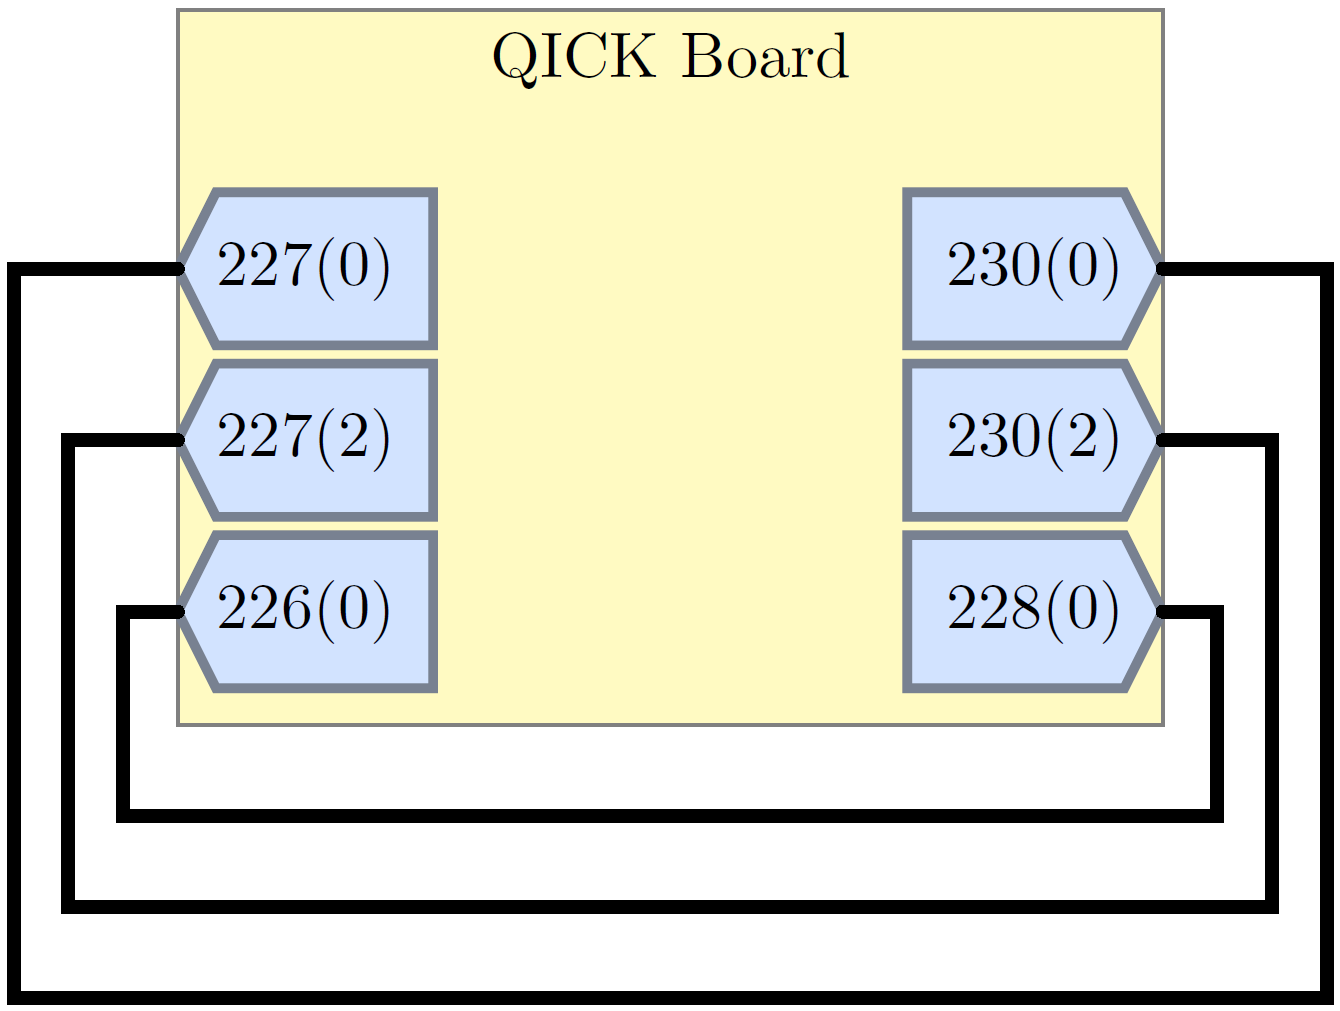

In [5]:
from IPython.display import Image, display
display(Image(filename='images/connections_demo03.png', embed=True))

In [ ]:
##########################################
### One generator/readout and raw-data ###
##########################################
class ReadoutTest(AveragerProgram):
    def initialize(self):
        # Set the nyquist zone for the DACs.
        self.declare_gen(ch=self.cfg["gen_ch"], nqz=1)
        
        # DAC channel.
        freq = self.freq2reg(self.cfg['pulse_freq'], gen_ch=self.cfg['gen_ch'], ro_ch=self.cfg['ro_ch'][0])
        self.default_pulse_registers(ch     = self.cfg['gen_ch'], 
                                     style  = 'const', 
                                     freq   = freq,
                                     gain   = self.cfg['pulse_gain'], 
                                     length = self.us2cycles(self.cfg['pulse_length'],gen_ch=self.cfg['gen_ch']))
        
        # Readout.
        self.declare_readout(ch      = self.cfg['ro_ch'][0], 
                             length  = self.us2cycles(self.cfg['ro_length'], ro_ch = self.cfg['ro_ch'][0]),
                             freq    = self.cfg['ro_freq'],
                             gen_ch  = self.cfg['gen_ch'])
        
        # Registers.
        self.set_pulse_registers(ch=self.cfg['gen_ch'], phase=0, phrst=0, mode="oneshot")
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):       
        self.measure(pulse_ch        = self.cfg['gen_ch'], 
                     adcs            = self.cfg['ro_ch'],
                     pins            = [0], 
                     adc_trig_offset = self.us2cycles(self.cfg['ro_offset'], ro_ch = self.cfg['ro_ch'][0]),
                     )        

config={"ro_ch"       : [4],
        "ro_length"   : 10,
        "ro_freq"     : 500,
        "ro_offset"   : 0,
        
        "gen_ch"      : 0,        
        "pulse_length": 7,
        "pulse_start" : 0,
        "pulse_gain"  : 30000,
        "pulse_freq"  : 501,
        
        "reps"        : 1,
        "period"      : 20
       }

prog = ReadoutTest(soccfg, config)
iq_list = prog.acquire_decimated(soc, load_pulses=True)

In [ ]:
# Plot Captured Data.
plt.figure(dpi=200)

# fs (MHz) and ts (us).
fs = soccfg['readouts'][config['ro_ch'][0]]['fs']/8
ts = 1000*1/fs

yi = iq_list[0][0]
yq = iq_list[0][1]
x = ts*np.arange(len(iq_list[0][0]))

plt.plot(x,yi)
plt.plot(x,yq)
    
plt.xlabel('t [ns]');
plt.legend(['I','Q']);  

In [ ]:
############################################
### Two generators/readouts and raw-data ###
############################################
class ReadoutMultiTest(AveragerProgram):
    def initialize(self):
        # Set the nyquist zone for the DACs.
        self.declare_gen(ch=self.cfg["gen_ch"][0], nqz=1, mixer_freq = self.cfg['mixer_freq'])
        self.declare_gen(ch=self.cfg["gen_ch"][1], nqz=1, mixer_freq = self.cfg['mixer_freq'])
        
        # First DAC channel.
        freq = self.freq2reg(self.cfg['pulse_freq'][0], gen_ch=self.cfg['gen_ch'][0], ro_ch=self.cfg['ro_ch'][0])
        self.default_pulse_registers(ch     = self.cfg['gen_ch'][0], 
                                     style  = 'const', 
                                     freq   = freq,
                                     gain   = self.cfg['pulse_gain'][0], 
                                     length = self.us2cycles(self.cfg['pulse_length'][0],gen_ch=self.cfg['gen_ch'][0]))
        
        # Second DAC channel.
        freq = self.freq2reg(self.cfg['pulse_freq'][1], gen_ch=self.cfg['gen_ch'][1], ro_ch=self.cfg['ro_ch'][1])
        self.default_pulse_registers(ch     = self.cfg['gen_ch'][1], 
                                     style  = 'const', 
                                     freq   = freq,
                                     gain   = self.cfg['pulse_gain'][1], 
                                     length = self.us2cycles(self.cfg['pulse_length'][1],gen_ch=self.cfg['gen_ch'][1]))
        
        # Readout.
        self.declare_readout(ch      = self.cfg['ro_ch'][0], 
                             length  = self.us2cycles(self.cfg['ro_length'], ro_ch = self.cfg['ro_ch'][0]),
                             freq    = self.cfg['ro_freq'][0],
                             gen_ch  = self.cfg['gen_ch'][0])
        
        self.declare_readout(ch      = self.cfg['ro_ch'][1], 
                             length  = self.us2cycles(self.cfg['ro_length'], ro_ch = self.cfg['ro_ch'][1]),
                             freq    = self.cfg['ro_freq'][1],
                             gen_ch  = self.cfg['gen_ch'][1])        
        
        # Registers.
        self.set_pulse_registers(ch=self.cfg['gen_ch'][0], phase=0, phrst=0, mode="oneshot")
        self.set_pulse_registers(ch=self.cfg['gen_ch'][1], phase=0, phrst=0, mode="oneshot")        
        
        self.synci(200)  # give processor some time to configure pulses        
    
    def body(self):               
        self.measure(pulse_ch        = self.cfg['gen_ch'], 
                     adcs            = self.ro_chs,
                     pins            = [0], 
                     adc_trig_offset = self.us2cycles(self.cfg['ro_offset'], ro_ch = self.cfg['ro_ch'][0]))
        
        self.synci(self.us2cycles(self.cfg['period']))        

config={"ro_ch"       : [4,6],
        "ro_length"   : 10,
        "ro_freq"     : [300,501],
        "ro_offset"   : 0.3,
        
        "mixer_freq"  : 1500,
        "gen_ch"      : [0,2],        
        "pulse_length": [5,6],
        "pulse_start" : [0,0],
        "pulse_gain"  : [20000,10000], # [DAC units]
        "pulse_freq"  : [300,502], # [MHz]
        
        "reps"        : 1,
        "period"      : 20
       }

prog = ReadoutMultiTest(soccfg, config)
iq_list = prog.acquire_decimated(soc, load_pulses=True)

In [ ]:
# Plot Captured Data.

# fs (MHz) and ts (us).
fs = soccfg['readouts'][config['ro_ch'][0]]['fs']/8
ts = 1000*1/fs

x = ts*np.arange(len(iq_list[0][0]))

# Channel 0.
yi = iq_list[0][0]
yq = iq_list[0][1]

plt.figure(dpi=200)
plt.plot(x,yi)
plt.plot(x,yq)
    
plt.xlabel('t [ns]');
plt.title('Channel 0');
plt.legend(['I','Q']);

# Channel 1.
yi = iq_list[1][0]
yq = iq_list[1][1]

plt.figure(dpi=200)
plt.plot(x,yi)
plt.plot(x,yq)
    
plt.xlabel('t [ns]');
plt.title('Channel 1');
plt.legend(['I','Q']);

In [ ]:
#############################################
### Calibrating readout length and offset ###
#############################################
config={"ro_ch"       : [4,6],
        "ro_length"   : 4,
        "ro_freq"     : [400,501],
        "ro_offset"   : 1,
        
        "mixer_freq"  : 1000,
        "gen_ch"      : [0,2],        
        "pulse_length": [5,6],
        "pulse_start" : [0,0],
        "pulse_gain"  : [20000,10000], # [DAC units]
        "pulse_freq"  : [400,501], # [MHz]
        
        "reps"        : 1,
        "period"      : 20
       }

prog = ReadoutMultiTest(soccfg, config)
iq_list = prog.acquire_decimated(soc, load_pulses=True)

In [ ]:
# Plot Captured Data.

# fs (MHz) and ts (us).
fs = soccfg['readouts'][config['ro_ch'][0]]['fs']/8
ts = 1000*1/fs

x = ts*np.arange(len(iq_list[0][0]))

# Channel 0.
yi = iq_list[0][0]
yq = iq_list[0][1]

plt.figure(dpi=200)
plt.plot(x,yi)
plt.plot(x,yq)
    
plt.xlabel('t [ns]');
plt.title('Channel 0');
plt.legend(['I','Q']);

# Channel 1.
yi = iq_list[1][0]
yq = iq_list[1][1]

plt.figure(dpi=200)
plt.plot(x,yi)
plt.plot(x,yq)
    
plt.xlabel('t [ns]');
plt.title('Channel 1');
plt.legend(['I','Q']);

In [ ]:
#########################################
### Multiple Averages over short time ###
#########################################
config['reps'] = 10
prog = ReadoutMultiTest(soccfg, config)
iq_list = prog.acquire(soc, load_pulses=True)

In [ ]:
# Plot data.
channel = 0
nsamp = prog.ro_chs[config['ro_ch'][channel]]['length']
di = prog.di_buf[channel]/nsamp
dq = prog.dq_buf[channel]/nsamp
diq = di + 1j*dq
a = np.abs(diq)
phi = np.angle(diq)
t = config['period']*np.arange(len(di))

plt.figure(dpi=150)
plt.plot(t,di,label="I")
plt.plot(t,di,'.')
plt.plot(t,dq,label="Q")
plt.plot(t,dq,'.')
plt.legend()
plt.xlabel("Time [us]");
plt.title("Channel {}".format(channel));

In [ ]:
###########################################
### Multiplexed Generator/Readout Chain ###
###########################################
class MuxReadoutTest(AveragerProgram):
    def initialize(self):
        # Declare Generator (Mux).
        self.declare_gen(ch=self.cfg["gen_ch"], nqz=1,
                         mixer_freq = self.cfg['mixer_freq'],
                         mux_freqs = self.cfg['pulse_freqs'],
                         mux_gains = self.cfg['pulse_gains'])
        
        # Declare Readouts.
        length = self.us2cycles(self.cfg['ro_length'], ro_ch=self.cfg['ro_ch'][0])
        for iCh, ch in enumerate(self.cfg['ro_ch']):
            self.declare_readout(ch     = ch,
                                 freq   = self.cfg['ro_freqs'][iCh],
                                 length = length,
                                 gen_ch = self.cfg['gen_ch'])
        
        # Pulse registers.
        length = self.us2cycles(self.cfg['pulse_length'], gen_ch=self.cfg['gen_ch'])
        self.set_pulse_registers(ch = self.cfg['gen_ch'], style = 'const', length=length, mask=[0,1])
        
        self.synci(200)
    
    def body(self):
        self.measure(pulse_ch        = self.cfg['gen_ch'], 
                     adcs            = self.ro_chs,
                     pins            = [0], 
                     adc_trig_offset = self.us2cycles(self.cfg['ro_offset'], ro_ch = self.cfg['ro_ch'][0]))
        
        self.synci(self.us2cycles(self.cfg['period']))

config={"ro_ch"       : [0,1],
        "ro_length"   : 10,
        "ro_freqs"    : [15,300],
        "ro_offset"   : 0,
        
        "gen_ch"      : 6,        
        "mixer_freq"  : 600,
        "pulse_length": 5,
        "pulse_freqs" : [15,300],
        "pulse_gains" : [0.5, 0.3],
        
        "reps"        : 1,
        "period"      : 20,
       }

prog = MuxReadoutTest(soccfg, config)
iq_list = prog.acquire_decimated(soc, load_pulses=True)

In [ ]:
# Plot Captured Data.

# fs (MHz) and ts (us).
fs = soccfg['readouts'][config['ro_ch'][0]]['fs']/8
ts = 1000*1/fs

x = ts*np.arange(len(iq_list[0][0]))

# Channel 0.
yi = iq_list[0][0]
yq = iq_list[0][1]

plt.figure(dpi=200)
plt.plot(x,yi)
plt.plot(x,yq)
    
plt.xlabel('t [ns]');
plt.title('Channel 0');
plt.legend(['I','Q']);

# Channel 1.
yi = iq_list[1][0]
yq = iq_list[1][1]

plt.figure(dpi=200)
plt.plot(x,yi)
plt.plot(x,yq)
    
plt.xlabel('t [ns]');
plt.title('Channel 1');
plt.legend(['I','Q']);

In [ ]:
###############################
### Multiplexed Readout PFB ###
###############################
N = 8
M = N/2
fs = soc.adcs['20']['fs']/soc.adcs['20']['decimation']
fc_ch = fs/N
fs_ch = fs/M
print("PFB Readout Parameters:")
print(" -> fs                = {} MHz".format(fs))
print(" -> Channel Distance  = {} MHz".format(fc_ch))
print(" -> Channel Bandwidth = {} MHz".format(fs_ch))
print()
print("PFB Band Assignment:")
for i in range(N):
    fc = i*fc_ch
    f0 = i*fc_ch - fs_ch/2
    f1 = i*fc_ch + fs_ch/2
    f0_flat = i*fc_ch - fs_ch/4
    f1_flat = i*fc_ch + fs_ch/4
    if i<M:
        fc += fs/2
        f0 += fs/2
        f1 += fs/2
        f0_flat += fs/2
        f1_flat += fs/2
    else:
        fc -= fs/2
        f0 -= fs/2
        f1 -= fs/2
        f0_flat -= fs/2
        f1_flat -= fs/2
    print("Channel {}: fc = {:>7.2f} MHz,Band = [{:>7.2f}, {:>7.2f}] MHz, Flat = [{:>7.2f}, {:>7.2f}] MHz"
          .format(i,fc,f0,f1,f0_flat,f1_flat))
    
#################################
### PFB Channels Side-by-Side ###
#################################
class MuxReadoutTest(AveragerProgram):
    def initialize(self):        
        # Declare Generator (Mux).
        self.declare_gen(ch=self.cfg["gen_ch"], nqz=1,
                         mixer_freq = self.cfg['mixer_freq'],
                         mux_freqs = self.cfg['pulse_freqs'],
                         mux_gains = self.cfg['pulse_gains'])
        
        # Declare Readouts.
        length = self.us2cycles(self.cfg['ro_length'], ro_ch=self.cfg['ro_ch'][0])
        self.declare_readout(ch     = self.cfg['ro_ch'][0],
                            freq   = self.cfg['ro_freq'],
                            length = length)
        
        # Pulse registers.
        length = self.us2cycles(self.cfg['pulse_length'], gen_ch=self.cfg['gen_ch'])
        self.set_pulse_registers(ch = self.cfg['gen_ch'], style = 'const', length=length, mask=[0,1])        
        
        self.synci(200)
    
    def body(self):
        self.measure(adcs = self.ro_chs, pins = [0], pulse_ch=self.cfg['gen_ch'])

config={"ro_ch"       : [0],
        "ro_length"   : 50,
        "ro_freq"     : 1,
        
        "gen_ch"      : 6,        
        "mixer_freq"  : 200,
        "pulse_length": 500,
        "pulse_freqs" : [50,230],
        "pulse_gains" : [0.2,0.1],        
        "reps"        : 1,
       }

# Frequency and amplitude vectors.
FF = []
AA = []
plt.figure(dpi=150);

# Loop over channel centers.
fc_v = np.arange(0, fs,fc_ch)
#fc_v = [614]
foffset = 0*fs_ch/4
for fck in fc_v:
    #print("Center Frequency: {:.2f} MHz".format(fck))
    
    # Update frequency.
    config['ro_freq'] = fck+foffset
    
    # Get data from channel.
    prog = MuxReadoutTest(soccfg, config)
    iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=False)    
    xi = iq_list[0][0]
    xq = iq_list[0][1]
    x = xi +1j*xq
    
    # Frequency vector.
    F = (np.arange(len(x))/len(x)-0.5)*fs_ch    
    w = np.hanning(len(x))
    xw = x*w
    YY = fftshift(fft(xw))
    YYlog = 20*np.log10(abs(YY))
    AA = np.concatenate((AA,YYlog))    
    
    Fk = F+fck
    FF = np.concatenate((FF,Fk))
    plt.plot(Fk,YYlog);
plt.xlabel("Frequency [MHz]");
plt.ylabel("Amplitude [dB]");   